### Preliminaries

In [1]:
# import libraries
import torch 
import numpy as np
from torch import nn 
from torch import optim
from torchvision import datasets, transforms 
from torch.utils.data import random_split, DataLoader
# Check cuda availbility 
print('CUDA is available!') if  torch.cuda.is_available() else print('No cuda')
# assign cuda to device
device = torch.device('cuda')
import matplotlib.pyplot as plt
# %matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


CUDA is available!


### RNN Example

#### Generate simple time series data

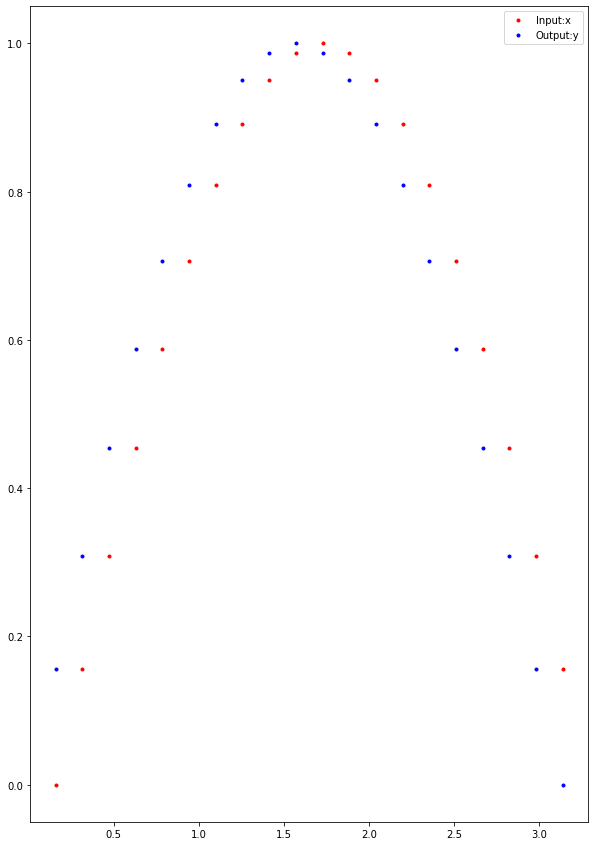

In [2]:
seq_length = 20
time_steps = np.linspace(0, np.pi, seq_length +1) # creating time steps in x axis
data = np.sin(time_steps) # creating data from time steps
data = data.reshape(-1,1)

# construct futur prediction task 

# all data except last point
x = data[:-1]
# all but first point
y = data[1:]

plt.figure(figsize=(10,15))
plt.plot(time_steps[1:], x, 'r.', label = 'Input:x')
plt.plot(time_steps[1:], y, 'b.', label = 'Output:y')

plt.legend()
plt.show()

#### Construct the RNN

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers):
        super().__init__()
        
        self.in_size = input_size 
        self.hid_dim = hidden_dim 
        self.out_size = output_size
        self.n_layer = n_layers
        
        # define simple RNN 
        # define the paramters accordingly
        # batch first means the first dimensions should be batch size
        self.rnn = nn.RNN(self.in_size, self.hid_dim, self.n_layer, batch_first=True) 
        
        # given the output from rnn, we pass to fc 
        self.fc = nn.Linear(self.hid_dim, self.out_size)
        
    def forward(self, x):

        # input shape to RNN: x (batch_size, seq_length, input_size)
        # hidden_dim shape : hid (n_layers, batch_size, hid_dim)
        # output shape from RNN: out (batch_size, seq_length, hid_dim)

        x = x.view(x.size(0), -1, self.in_size)
        
        rnn_out, rnn_hid = self.rnn(x)

        # 1- reshape the output to be rnn_out.view(batch_size*seq_length, hidden_dim) 
        # 2- or just take the last time step in the rnn: rnn_out[:, -1, :]

        # get final out by reshaping 
        final_out =  self.fc(rnn_out.view(-1, self.hid_dim))

        # get final out by picking the last hid dim
        
        return final_out, rnn_hid 



#### test input and output dim from RNN

In [4]:
# create object model from RNN class 
input_size =1
seq_length = 20
output_size = 1
hidden_dim = 10
n_layers = 2
test_rnn = RNN(input_size, hidden_dim, output_size,n_layers)

# convert data to tensors 
# make it (1, seq_length, input_size), where batch size is 1 
# make sure to make the input float
test_data = torch.tensor(data).unsqueeze(0).float()

print(f'Input size: {test_data.size()}')

# forward pass 
test_out_v1, hid_dim = test_rnn(test_data)
      
print(f'Output size: {test_out_v1.size()}') # (batch_size, sequence_length, output_size)
print(f'Hidden size: {hid_dim.size()}')  # ( n_layers, batch_size, hidden_dim)


Input size: torch.Size([1, 21, 1])
Output size: torch.Size([21, 1])
Hidden size: torch.Size([2, 1, 10])


#### Training the RNN network

In [5]:
def train_rnn(model, n_steps, print_every):
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1
        
        # predicting next time step task
        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0).float() # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = model(x_tensor)

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.', label='Ground Truth') # input
            plt.plot(time_steps[1:], prediction.detach().numpy().flatten(), 'b.', label= 'Prediction') # predictions
            plt.legend()
            plt.show()
    
    return model

#### construct the rnn model

In [6]:
# create object model from RNN class 
input_size =1
seq_length = 20
output_size = 1
hidden_dim = 16
n_layers = 1
my_rnn = RNN(input_size, hidden_dim, output_size,n_layers)

#### Define optmizer and loss

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_rnn.parameters(), lr= 0.01)

#### Run the train loop

Loss:  0.7428628206253052


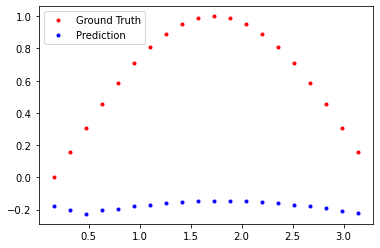

Loss:  0.04001283273100853


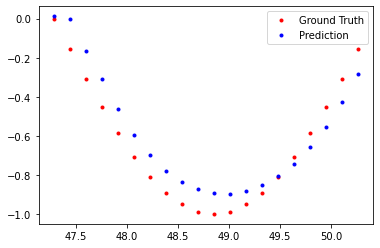

Loss:  0.01421145349740982


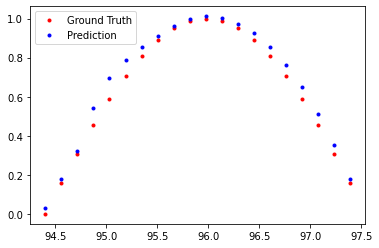

Loss:  0.010333009995520115


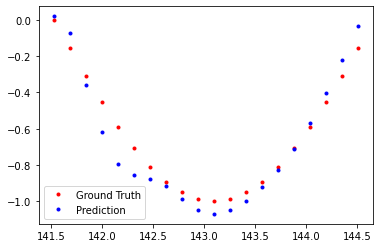

Loss:  0.004471317864954472


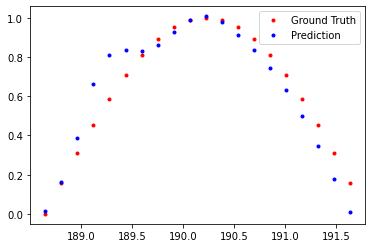

In [8]:
# define params
n_steps = 75
print_every = 15

trained_model = train_rnn(my_rnn, n_steps, print_every)